In [ ]:
#importing some libraries
import numpy as np 
import pandas as pd 
from sklearn.metrics import accuracy_score 
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from joblib import dump,load
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

**Custom SVM model**

In [ ]:
####################################################################
#Custom SVM
####################################################################

class SVM():

  def check_convergence(W, X, Y,lambda_val):
      reg_strength=lambda_val # Lambda 
      # hinge loss
      total_terms = X.shape[0]
      y_obt =1- Y * (np.dot(X, W)) # The const term(b) is absorbed in the Weight vector
      y_obt[y_obt < 0] = 0  # equating all the negative values of y*w_trans*x-1 to zero
      hinge_loss = (np.sum(y_obt) / total_terms)
      
      # calculated cost(We should minimise the cost, this is same as the lagrangian that we saw for a given constrait i.e the hinge loss)
      cost = 0.5 * np.dot(W, W) + (reg_strength*hinge_loss) #langrangian
      return cost



  def cost_gradient(W, X_batch, Y_batch,lambda_val):
    reg_strength=lambda_val #lambda
    Y_batch = np.array([Y_batch]) # Since single entries will be passed and we need to convert them to nuumpy array
    X_batch = np.array([X_batch])    
    y_obt = 1 - (Y_batch * np.dot(X_batch, W))
    dw= np.zeros(len(W))    # initializing the gradient to be zero
    for ind,d in enumerate(y_obt):
      if max(0, d) == 0:
        w = W
      else:
        w = W - (reg_strength * Y_batch[ind] * X_batch[ind])
      dw += w
    dw = dw/len(Y_batch)  # Normalising
    return dw

  #Now we have to minimise this cost function, since it is a convex optimisation problem , therefore we will use gradient descent 

  def fit(features, outputs,max_epochs,reg,cost_threshold,learning_rate):
      weights = np.zeros(features.shape[1])
      n_ind = 0
      prev_cost = float("inf")
      # SGD
      for epoch in range(1, max_epochs):
        # shuffle to prevent repeating update cycles
        X, Y = shuffle(features, outputs)
        for ind, x in enumerate(X):
          ascent = SVM.cost_gradient(weights, x, Y[ind],reg)
          weights = weights - (learning_rate * ascent)        # checking convergence on every 2^nth epoch
        if epoch == 2 ** n_ind or epoch == max_epochs - 1:
          cost = SVM.check_convergence(weights, features, outputs,reg)
          print(f"Epoch is:{epoch} and corresponding Cost is: {cost}")
          # stoppage when converge is achieved
          if abs(prev_cost - cost) < cost_threshold*prev_cost:
            print('Training Finished!!')
            return weights
          prev_cost = cost
          n_ind += 1
      print('Training Finished!!')
      return weights
  
  def predict(X_test,W):
    y_test_predicted = [] # Defining an empty array 
    itr=X_test.shape[0]
    scaled_X_test=X_test
    for i in range(itr):
      yp = np.sign(np.dot(W,scaled_X_test[i])) #model
      y_test_predicted.append(yp)
    y_test_predicted=np.array(y_test_predicted)
    y_test_predicted=np.where(y_test_predicted==-1,0,1)
    return y_test_predicted




**Importing data and some visualizations**

In [ ]:
# Importing the CBM data
df1=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PP detector data for svm/mixed.csv')

In [ ]:
df1.shape

(215343, 16)

In [ ]:

df1.head(3)

,EvNo,trumu,chargesg,px,py,pz,E,muchhits,stshits,trdhits,tofhits,chisqmuch,chisqsts,chisqtrd,chisqvertex,tofmass
0,1,1,-1,0.853275,-0.847333,7.35208,7.45053,11,8,3,1,1.97966,3.15940,9.20906,2.96263,0.031319
1,2,0,1,-0.431410,-0.554361,4.25411,4.31301,9,8,3,0,3.89112,1.51397,22.56260,1.23243,-1000.000000
2,2,1,-1,0.217476,0.837259,5.95573,6.01915,11,7,4,1,1.61583,2.68982,1.63692,2.96849,-0.057862


In [ ]:
df1.describe()

,EvNo,trumu,chargesg,px,py,pz,E,muchhits,stshits,trdhits,tofhits,chisqmuch,chisqsts,chisqtrd,chisqvertex,tofmass
count,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000,215343.000000
mean,49979.234686,0.421379,0.364484,-0.017657,0.001103,4.558340,4.688084,10.363165,7.227275,2.414910,0.610881,3.218225,2.203597,9.332001,3.302467,-389.099845
std,28844.793038,0.493781,0.931212,0.805256,0.802046,1.658026,1.688956,1.446410,1.118722,1.287867,0.487551,16.414954,6.663640,20.039042,15.357899,487.575542
min,1.000000,0.000000,-1.000000,-28.561900,-16.714800,1.294410,1.368920,7.000000,3.000000,1.000000,0.000000,-48.171700,-710.789000,0.068500,0.002282,-1000.000000
25%,25021.000000,0.000000,-1.000000,-0.545848,-0.519007,3.235870,3.321125,9.000000,7.000000,1.000000,0.000000,1.878140,0.897996,2.419305,0.751344,-1000.000000
50%,49922.000000,0.000000,1.000000,0.018386,0.005550,4.127940,4.272240,11.000000,8.000000,2.000000,1.000000,2.534960,1.314370,5.682530,1.292230,-0.023455
75%,74944.000000,1.000000,1.000000,0.460751,0.520416,5.568565,5.739910,12.000000,8.000000,4.000000,1.000000,3.871795,2.073570,14.280000,2.236525,0.005579
max,99999.000000,1.000000,1.000000,21.820600,16.667700,115.071000,118.827000,12.000000,8.000000,4.000000,1.000000,7201.020000,1388.750000,7441.030000,3641.070000,1131.570000


In [ ]:
# Checking the ratio of Signal VS background
df1['trumu'].value_counts()

0    124602
1     90741
Name: trumu, dtype: int64

In [ ]:
df1=df1.reset_index()
df1.drop(columns='index',inplace=True)

<h3>Removing the outliers</h3>

In [ ]:
# Removing the outliers first using IQR

#Px

Q1=df1['px'].quantile(0.50)
Q3=df1['px'].quantile(0.75)
print(f'Q1 : {Q1} , Q3 : {Q3}')
IQR=Q3-Q1
print(f'IQR value {IQR}')

#Lower and upper boundary
lower_boundary=Q1-(1.5*IQR)
upper_boundary=Q3+(1.5*IQR)

print(f"Upper boundary is {upper_boundary} , Lower Boundary is {lower_boundary}")

Q1 : 0.0183861 , Q3 : 0.4607505
IQR value 0.4423644
Upper boundary is 1.1242971 , Lower Boundary is -0.6451605


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


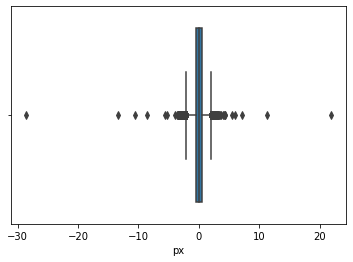

In [ ]:
#Visualizing the outliers using Box plot
sns.boxplot(df1['px'])

In [ ]:
df1[(df1['px']<=-20) | (df1['px']>=20)]

,EvNo,trumu,chargesg,px,py,pz,E,muchhits,stshits,trdhits,tofhits,chisqmuch,chisqsts,chisqtrd,chisqvertex,tofmass


In [ ]:
df1.drop([25342,189417],inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


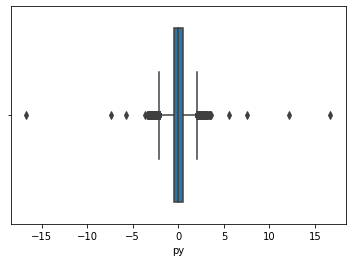

In [ ]:
# Py
sns.boxplot(df1['py'])

In [ ]:
outlier_py=df1[(df1['py']<-10) | (df1['py']>10)]

In [ ]:
outlier_py

,EvNo,trumu,chargesg,px,py,pz,E,muchhits,stshits,trdhits,tofhits,chisqmuch,chisqsts,chisqtrd,chisqvertex,tofmass


In [ ]:
py_drop=outlier_py.index.tolist()

In [ ]:
py_drop

[15437, 81013, 133952]

In [ ]:
df1.drop(py_drop,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


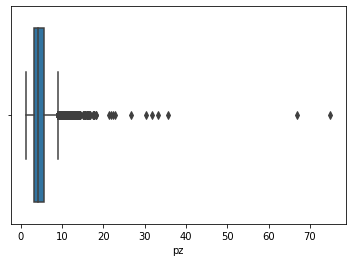

In [ ]:
# Pz
sns.boxplot(df1['pz'])
outlier_pz=df1[df1['pz']>40]
pz_drop=outlier_pz.index.tolist()
df1.drop(pz_drop,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


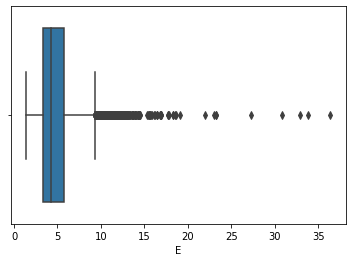

In [ ]:
# Energy
sns.boxplot(df1['E'])
outlier_E=df1[df1['E']>25]
E_drop=outlier_E.index.tolist()
df1.drop(E_drop,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


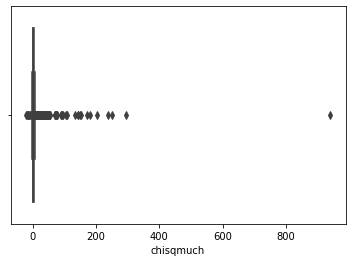

In [ ]:
# chisqmuch
sns.boxplot(df1['chisqmuch'])
outlier_much=df1[df1['chisqmuch']>400]
much_drop=outlier_much.index.tolist()
df1.drop(much_drop,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


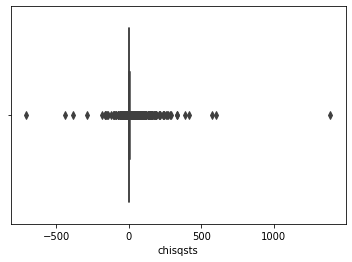

In [ ]:
# chisqsts
sns.boxplot(df1['chisqsts'])
outlier_sts=df1[(df1['chisqsts']<=-300) | (df1['chisqsts']>500)]
sts_drop=outlier_sts.index.tolist()
df1.drop(sts_drop,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


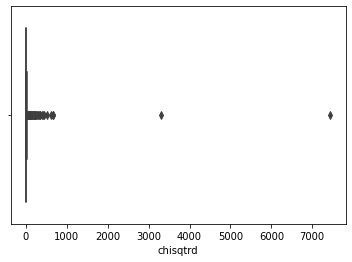

In [ ]:
# chisqtrd
sns.boxplot(df1['chisqtrd'])
outlier_trd=df1[df1['chisqtrd']>1000]
trd_drop=outlier_trd.index.tolist()
df1.drop(trd_drop,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


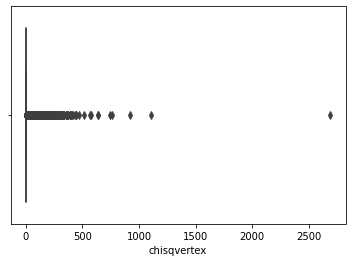

In [ ]:
# chisqvertex
sns.boxplot(df1['chisqvertex'])
outlier_vertex=df1[df1['chisqvertex']>800]
vertex_drop=outlier_vertex.index.tolist()
df1.drop(vertex_drop,inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


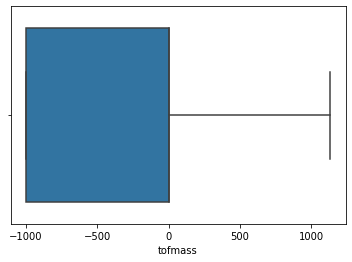

In [ ]:
#tof
sns.boxplot(df1['tofmass'])

In [ ]:
#resetting the index
df1=df1.reset_index()
df1.drop(columns=['index'],inplace=True)

In [ ]:
df1.shape

(215317, 18)

In [ ]:
# Creating X and target column

X=df1.drop(columns=['trumu','EvNo'])
y=df1['trumu']

<h3>Scaling the data</h3>

In [ ]:
# Scaling the data with between -1 and 1

scaling=StandardScaler()
X_scaled=scaling.fit_transform(X)

In [ ]:
#Converting numpy object into DataFrame

X_scaled=pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.head(3)

,chargesg,px,py,pz,E,muchhits,stshits,trdhits,tofhits,chisqmuch,chisqsts,chisqtrd,chisqvertex,tofmass
0,-1.465245,1.088991,-1.061817,1.754243,1.704272,0.440314,0.69072,0.454367,0.798150,-0.504545,0.184513,-0.007331,-0.025486,0.798136
1,0.682480,-0.517359,-0.695137,-0.188849,-0.229136,-0.942399,0.69072,0.454367,-1.252898,0.309192,-0.132185,1.366835,-0.178525,-1.252875
2,-1.465245,0.293998,1.046596,0.878432,0.822225,0.440314,-0.20323,1.230845,0.798150,-0.659432,0.094132,-0.786553,-0.024968,0.797953


In [ ]:
# Adding the target variable also just for visualization

X_visu=X_scaled
X_visu['target']=y

**Visualizing the distrinution of data**

In [ ]:
#Function to plot the histograms where names are list of strings

def histogram(X_data,names):
  for name in names:
    plt.figure(figsize=(4,4))
    plt.xlabel(name)
    plt.ylabel('Value')
    plt.title(f"Histogram for {name}")
    plt.hist(x=X_data[name],bins=30)
    plt.show()
    plt.savefig(str("hist"+name),dpi=125)

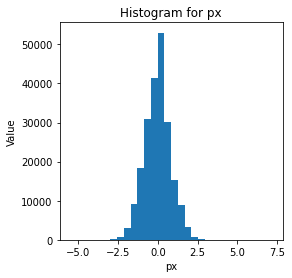

<Figure size 432x288 with 0 Axes>

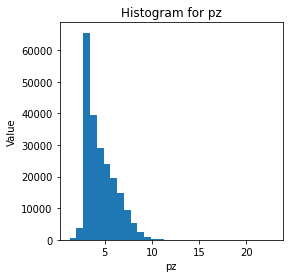

<Figure size 432x288 with 0 Axes>

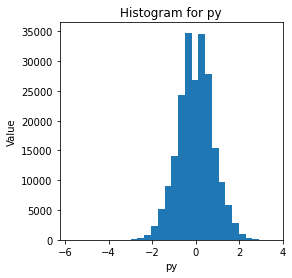

<Figure size 432x288 with 0 Axes>

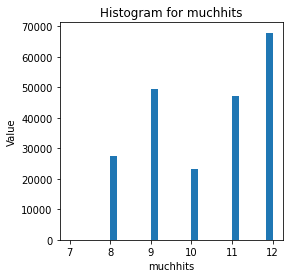

<Figure size 432x288 with 0 Axes>

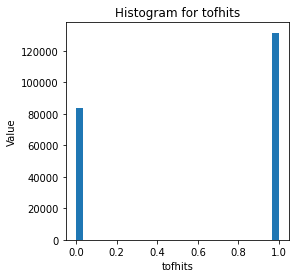

<Figure size 432x288 with 0 Axes>

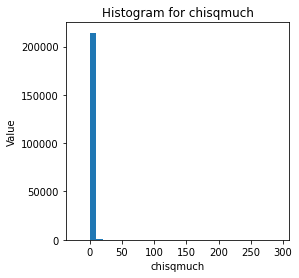

<Figure size 432x288 with 0 Axes>

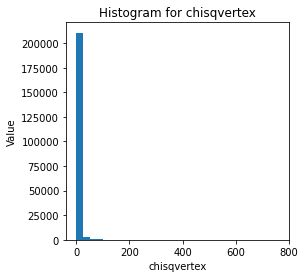

<Figure size 432x288 with 0 Axes>

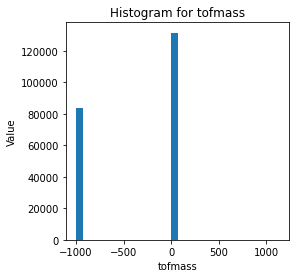

<Figure size 432x288 with 0 Axes>

In [ ]:
histogram(df1,['px','pz','py','muchhits','tofhits','chisqmuch','chisqvertex','tofmass'])



# we can see that none of the plots have a normal(gaussian) distribution expect px and py here,so SVM with gaussian kernel will not work much here


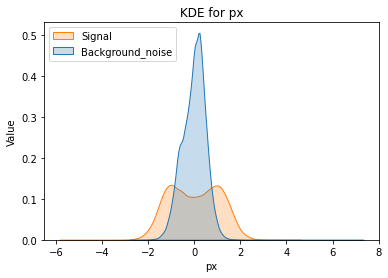

<Figure size 432x288 with 0 Axes>

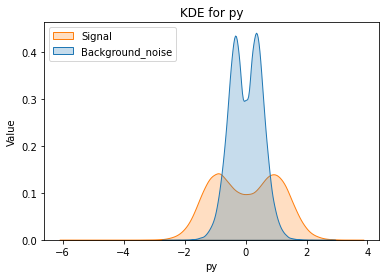

<Figure size 432x288 with 0 Axes>

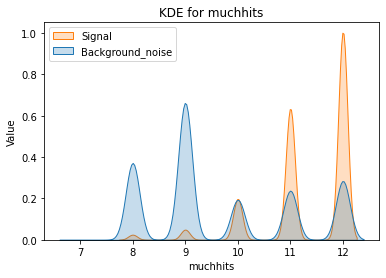

<Figure size 432x288 with 0 Axes>

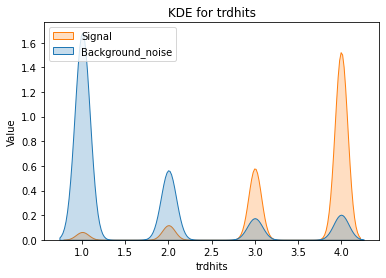

<Figure size 432x288 with 0 Axes>

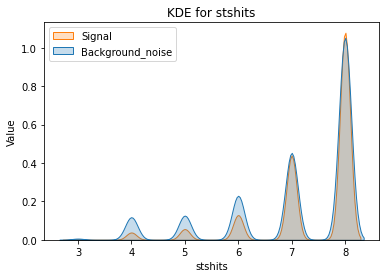

<Figure size 432x288 with 0 Axes>

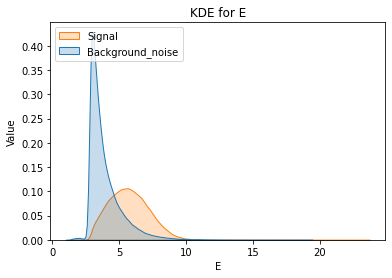

<Figure size 432x288 with 0 Axes>

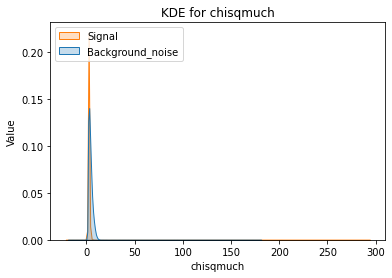

<Figure size 432x288 with 0 Axes>

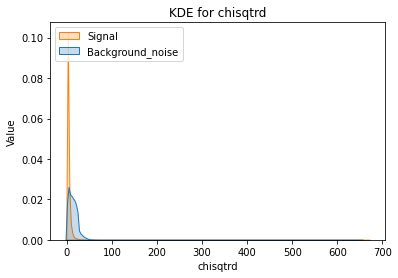

<Figure size 432x288 with 0 Axes>

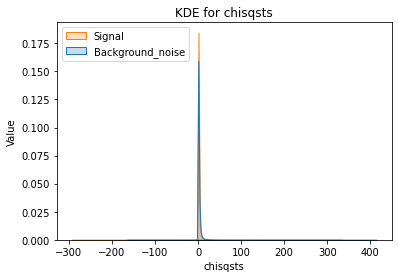

<Figure size 432x288 with 0 Axes>

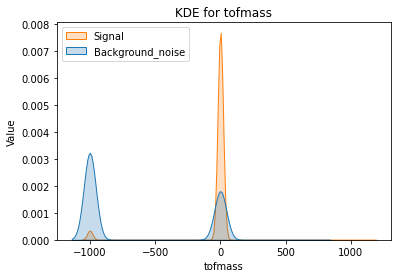

<Figure size 432x288 with 0 Axes>

In [ ]:
###################################################################################################################
# plotting a kde plot for all the variables to visualize the distribution to see the backgroung and signal overlapp 
###################################################################################################################

def kde_fucntion(data_pts,names):
  for name in names:
    plt.figure(figsize=(6,4))
    plt.xlabel(name)
    plt.ylabel('Value')
    plt.title(f"KDE for {name}")
    sns.kdeplot(x=name,data=data_pts,hue='trumu',shade=True)
    plt.legend(['Signal','Background_noise'],loc='upper left')
    plt.show()
    plt.savefig('new.jpeg', dpi=125)

kde_fucntion(df1,['px','py','muchhits','trdhits','stshits','E','chisqmuch','chisqtrd','chisqsts','tofmass'])

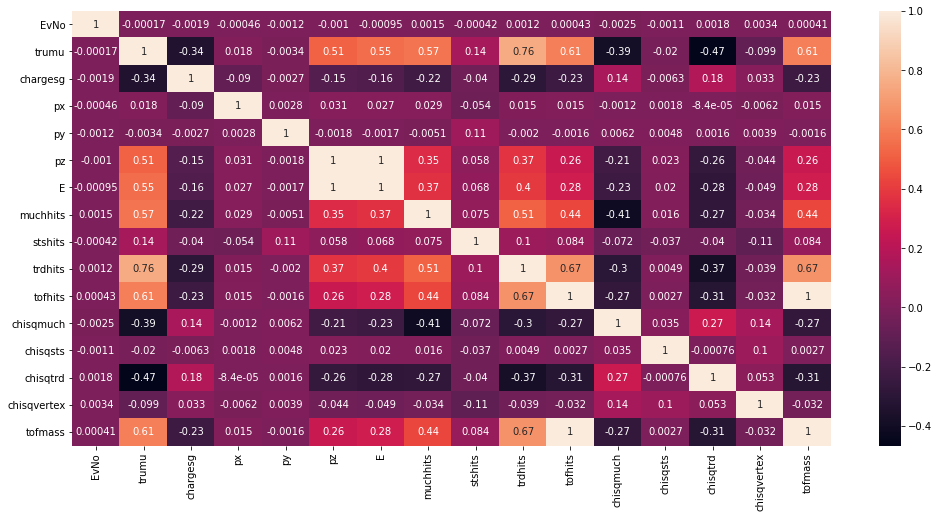

In [ ]:
#######################################################################
#Checking the coorealtion between the various columns
#######################################################################

corr_data=df1.corr()
plt.figure(figsize=(17,8))
sns.heatmap(corr_data,annot=True)

**Feature engineering**

In [ ]:
#########################################################################################
#(Energy / Sum of squared momentum) which gives mass
#########################################################################################



pSq_total=np.square(df1['px'])+np.square(df1['py'])+np.square(df1['pz'])
df1['E/p_square']=(df1['E']/pSq_total)
df1['mass']=0.5*df1['E/p_square'] ## mass of the particle
df1[['trumu','E','E/p_square','mass']].corr()


,trumu,E,E/p_square,mass
trumu,1.000000,0.550229,-0.585730,-0.585730
E,0.550229,1.000000,-0.939571,-0.939571
E/p_square,-0.585730,-0.939571,1.000000,1.000000
mass,-0.585730,-0.939571,1.000000,1.000000


In [ ]:
############################################################################################
#Removing the outliners chisquare values
############################################################################################




**Performing some more feature extraction and visualization**

Text(0.5, 1.0, 'How mean mass varies with much hits')

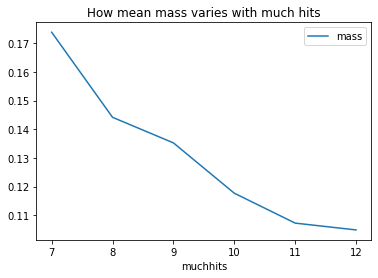

In [ ]:
# Checking some groupby informations


pz_hit=pd.DataFrame(df1,columns=df1.columns).groupby(['muchhits'])
pz_hit[['mass']].mean().plot()
plt.title('How mean mass varies with much hits')
# This shows that as the particle goes to the muon chmabers its mass goes on decreasing and as it reaches
# the final chamber its has the minimum mass

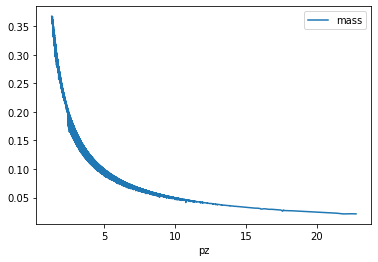

In [ ]:
pz_hit=pd.DataFrame(df1,columns=df1.columns).groupby(['pz'])
pz_hit[['mass']].mean().plot()

# This shows that as the pz increases the average mass of the particles goes on decreasing

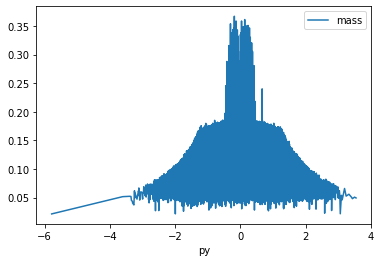

In [ ]:
pz_hit=pd.DataFrame(df1,columns=df1.columns).groupby(['py'])
pz_hit[['mass']].mean().plot()

# This show that the y component of momentum of the particles are approximately zero centred.Therefore we see a gaussian 
# type distribution here

**RE Scaling the data**

In [ ]:
# Creating X and target column

X=df1.drop(columns=['trumu','EvNo','E/p_square'])
y=df1['trumu']
# Scaling the data with between -1 and 1

scaling=StandardScaler()
X_scaled=scaling.fit_transform(X)

#Converting numpy object into DataFrame

X_scaled=pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.head(3)

,chargesg,px,py,pz,E,muchhits,stshits,trdhits,tofhits,chisqmuch,chisqsts,chisqtrd,chisqvertex,tofmass,mass
0,-1.465245,1.088991,-1.061817,1.754243,1.704272,0.440314,0.69072,0.454367,0.798150,-0.504545,0.184513,-0.007331,-0.025486,0.798136,-1.402180
1,0.682480,-0.517359,-0.695137,-0.188849,-0.229136,-0.942399,0.69072,0.454367,-1.252898,0.309192,-0.132185,1.366835,-0.178525,-1.252875,-0.075875
2,-1.465245,0.293998,1.046596,0.878432,0.822225,0.440314,-0.20323,1.230845,0.798150,-0.659432,0.094132,-0.786553,-0.024968,0.797953,-0.968785


**Train test split**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=42)

**Predictions Visulization**

In [ ]:
###################################################
## Simple functions for visualization of the models
###################################################

def scoring(y_test,predictions):
  conf_matrix=confusion_matrix(y_test,predictions)
  print(sns.heatmap(data=conf_matrix,annot=True,fmt='d'))
  print("\n",classification_report(y_test,predictions))


def roc_plot(y_test,predictions):
  fpr, tpr, thresholds=roc_curve(y_test,predictions)
  plt.figure(figsize=(7,7))
  plt.plot([0, 1], [0, 1], '--',color='red',label='Thresold')
  plt.plot(fpr, tpr,color='blue',label='Custom_svm')
  plt.ylabel('True positive rate(Recall)')
  plt.xlabel('False positive rate')
  plt.title('ROC')
  plt.grid()
  plt.legend()
  plt.show()
  print(f"The fpr is {fpr}, the tpr is {tpr}")






**Training the Custom SVM**

In [ ]:
###################################################################################################
#.fit() demands variables X,y,maximum epochs,regularisation(lambda value),cost_thresold_value,learning rate
####################################################################################################

model_custom=SVM
weights=model_custom.fit(X_train.to_numpy(),y_train.to_numpy(),1000,5000,0.001,0.0000001)

Epoch is:1 and corresponding Cost is: 3079.7503719156894
Epoch is:2 and corresponding Cost is: 3072.5142870934606
Epoch is:4 and corresponding Cost is: 3064.0409010849608
Epoch is:8 and corresponding Cost is: 3057.2689228223066
Epoch is:16 and corresponding Cost is: 3051.4252734428183
Epoch is:32 and corresponding Cost is: 3044.4571418483897
Epoch is:64 and corresponding Cost is: 3041.1383551230974
Epoch is:128 and corresponding Cost is: 3041.4863544044256
Training Finished!!


AxesSubplot(0.125,0.125;0.62x0.755)

               precision    recall  f1-score   support

           0       0.98      0.89      0.94     24893
           1       0.87      0.98      0.92     18176

    accuracy                           0.93     43069
   macro avg       0.93      0.93      0.93     43069
weighted avg       0.93      0.93      0.93     43069



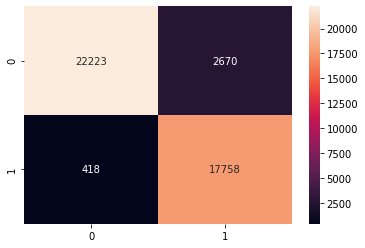

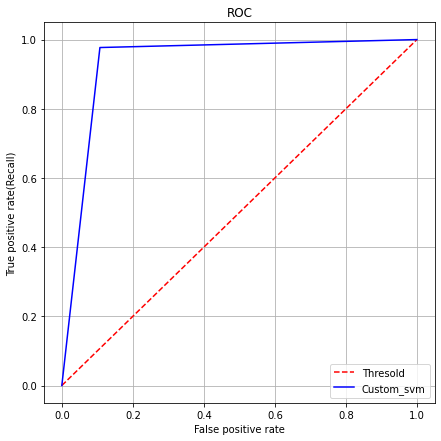

The fpr is [0.         0.10725907 1.        ], the tpr is [0.         0.97700264 1.        ]


In [ ]:
##################################
#predictions for custom svm
##################################

predictions_custom=model_custom.predict(X_test.to_numpy(),weights)
scoring(y_test,predictions_custom)
roc_plot(y_test,predictions_custom)

**Training SVM model**

In [ ]:
######################################
# Training linear SVC model 
######################################


model_svc=SVC(kernel='rbf')
model_svc.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

AxesSubplot(0.125,0.125;0.62x0.755)

               precision    recall  f1-score   support

           0       0.98      0.97      0.98     24891
           1       0.96      0.98      0.97     18173

    accuracy                           0.97     43064
   macro avg       0.97      0.97      0.97     43064
weighted avg       0.97      0.97      0.97     43064



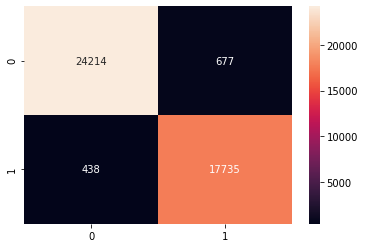

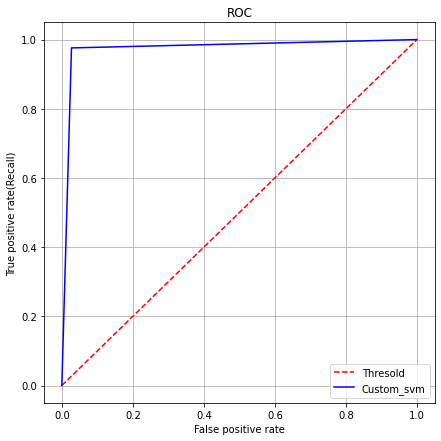

The fpr is [0.         0.02719859 1.        ], the tpr is [0.         0.97589831 1.        ]


In [ ]:
########################################
#predictions for SVC model
########################################

predictions_svc=model_svc.predict(X_test)
scoring(y_test,predictions_svc)
roc_plot(y_test,predictions_svc)

**Training boosted decision tree**

In [ ]:
####################################################
# Training Random Forest with default parameters
####################################################

model_rf=RandomForestClassifier()
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

AxesSubplot(0.125,0.125;0.62x0.755)

               precision    recall  f1-score   support

           0       0.98      0.97      0.98     24891
           1       0.97      0.97      0.97     18173

    accuracy                           0.97     43064
   macro avg       0.97      0.97      0.97     43064
weighted avg       0.97      0.97      0.97     43064



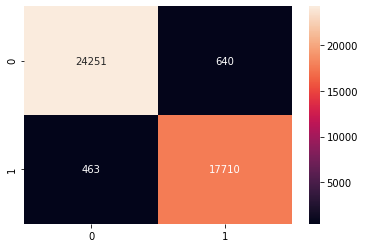

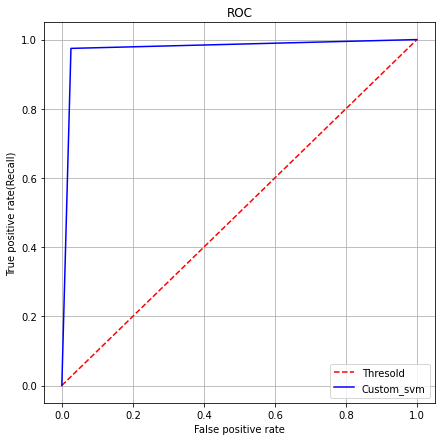

The fpr is [0.        0.0257121 1.       ], the tpr is [0.         0.97452264 1.        ]


In [ ]:
predictions_ada=model_rf.predict(X_test)
scoring(y_test,predictions_ada)
roc_plot(y_test,predictions_ada)

**ROC comparison of all models**

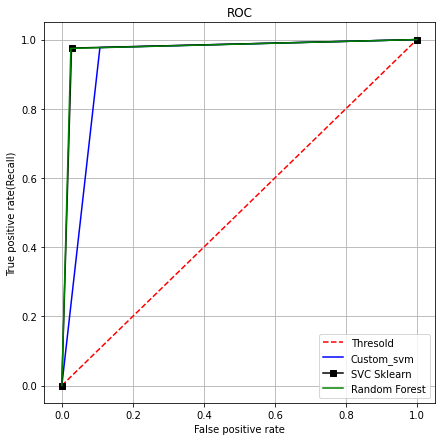

In [ ]:
y_custom=model_custom.predict(X_test.to_numpy(),weights)
y_svm=model_svc.predict(X_test)
y_rf=model_rf.predict(X_test)
fpr_custom, tpr_custom, thresholds1=roc_curve(y_test,y_custom)
fpr_svc, tpr_svc, thresholds2=roc_curve(y_test,y_svm)
fpr_rf, tpr_rf, thresholds3=roc_curve(y_test,y_rf)


plt.figure(figsize=(7,7))
plt.plot([0, 1], [0, 1], '--',color='red',label='Thresold')
plt.plot(fpr_custom, tpr_custom,color='blue',label='Custom_svm')
plt.plot(fpr_svc, tpr_svc,marker='s',color='black',label='SVC Sklearn')
plt.plot(fpr_rf, tpr_rf,color='green',label='Random Forest')
plt.ylabel('True positive rate(Recall)')
plt.xlabel('False positive rate')
plt.title('ROC')
plt.grid()
plt.legend()
plt.show()

**Saving all models**

In [ ]:
models=['Custom SVM',
       'SVM Sklearn',
       'boosted decsion Tree'
]
f1_score=[0.92,0.97,0.97]
df_scores=pd.DataFrame(data=f1_score,index=models,columns=['F1 score'])

In [ ]:
df_scores

,F1 score
Custom SVM,0.92
SVM Sklearn,0.97
boosted decsion Tree,0.97
